In [3]:
%pip install numpy scikit-learn

### Vectorización de texto y modelo de clasificación Naïve Bayes con el dataset 20 newsgroups

In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import f1_score

# 20newsgroups por ser un dataset clásico de NLP ya viene incluido y formateado
# en sklearn
from sklearn.datasets import fetch_20newsgroups
import numpy as np

## Carga de datos

In [5]:
# cargamos los datos (ya separados de forma predeterminada en train y test)
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

## Vectorización

In [6]:
# instanciamos un vectorizador
# ver diferentes parámetros de instanciación en la documentación de sklearn https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tfidfvect = TfidfVectorizer()

In [7]:
# en el atributo `data` accedemos al texto
print(newsgroups_train.data[0])

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


In [8]:
# con la interfaz habitual de sklearn podemos fitear el vectorizador
# (obtener el vocabulario y calcular el vector IDF)
# y transformar directamente los datos
X_train = tfidfvect.fit_transform(newsgroups_train.data)
# `X_train` la podemos denominar como la matriz documento-término

In [9]:
# recordar que las vectorizaciones por conteos son esparsas
# por ello sklearn convenientemente devuelve los vectores de documentos
# como matrices esparsas
print(type(X_train))
print(f'shape: {X_train.shape}')
print(f'Cantidad de documentos: {X_train.shape[0]}')
print(f'Tamaño del vocabulario (dimensionalidad de los vectores): {X_train.shape[1]}')

<class 'scipy.sparse._csr.csr_matrix'>
shape: (11314, 101631)
Cantidad de documentos: 11314
Tamaño del vocabulario (dimensionalidad de los vectores): 101631


In [10]:
# una vez fiteado el vectorizador, podemos acceder a atributos como el vocabulario
# aprendido. Es un diccionario que va de términos a índices.
# El índice es la posición en el vector de documento.
tfidfvect.vocabulary_['car']

25775

In [11]:
# es muy útil tener el diccionario opuesto que va de índices a términos
idx2word = {v: k for k,v in tfidfvect.vocabulary_.items()}

In [12]:
# en `y_train` guardamos los targets que son enteros
y_train = newsgroups_train.target
y_train[:10]

array([ 7,  4,  4,  1, 14, 16, 13,  3,  2,  4])

In [13]:
# hay 20 clases correspondientes a los 20 grupos de noticias
print(f'clases {np.unique(newsgroups_test.target)}')
newsgroups_test.target_names

clases [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

## Similaridad de documentos

In [14]:
# Veamos similaridad de documentos. Tomemos algún documento
idx = 4811
print(newsgroups_train.data[idx])

THE WHITE HOUSE

                  Office of the Press Secretary
                   (Pittsburgh, Pennslyvania)
______________________________________________________________
For Immediate Release                         April 17, 1993     

             
                  RADIO ADDRESS TO THE NATION 
                        BY THE PRESIDENT
             
                Pittsburgh International Airport
                    Pittsburgh, Pennsylvania
             
             
10:06 A.M. EDT
             
             
             THE PRESIDENT:  Good morning.  My voice is coming to
you this morning through the facilities of the oldest radio
station in America, KDKA in Pittsburgh.  I'm visiting the city to
meet personally with citizens here to discuss my plans for jobs,
health care and the economy.  But I wanted first to do my weekly
broadcast with the American people. 
             
             I'm told this station first broadcast in 1920 when
it reported that year's presidential elec

In [15]:
# midamos la similaridad coseno con todos los documentos de train
cossim = cosine_similarity(X_train[idx], X_train)[0]

In [16]:
# podemos ver los valores de similaridad ordenados de mayor a menos
np.sort(cossim)[::-1]

array([1.        , 0.70930477, 0.67474953, ..., 0.        , 0.        ,
       0.        ])

In [17]:
# y a qué documentos corresponden
np.argsort(cossim)[::-1]

array([4811, 6635, 4253, ..., 9019, 9016, 8748])

In [18]:
# los 5 documentos más similares:
mostsim = np.argsort(cossim)[::-1][1:6]

In [19]:
# el documento original pertenece a la clase:
newsgroups_train.target_names[y_train[idx]]

'talk.politics.misc'

In [20]:
# y los 5 más similares son de las clases:
for i in mostsim:
  print(newsgroups_train.target_names[y_train[i]])

talk.politics.misc
talk.politics.misc
talk.politics.misc
talk.politics.misc
talk.politics.misc


### Modelo de clasificación Naïve Bayes

In [21]:
# es muy fácil instanciar un modelo de clasificación Naïve Bayes y entrenarlo con sklearn
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

In [22]:
# con nuestro vectorizador ya fiteado en train, vectorizamos los textos
# del conjunto de test
X_test = tfidfvect.transform(newsgroups_test.data)
y_test = newsgroups_test.target
y_pred =  clf.predict(X_test)

In [23]:
# el F1-score es una metrica adecuada para reportar desempeño de modelos de claificación
# es robusta al desbalance de clases. El promediado 'macro' es el promedio de los
# F1-score de cada clase. El promedio 'micro' es equivalente a la accuracy que no
# es una buena métrica cuando los datasets son desbalanceados
f1_score(y_test, y_pred, average='macro')

0.5854345727938506

### Consigna del desafío 1

**1**. Vectorizar documentos. Tomar 5 documentos al azar y medir similaridad con el resto de los documentos.
Estudiar los 5 documentos más similares de cada uno analizar si tiene sentido
la similaridad según el contenido del texto y la etiqueta de clasificación.

**2**. Entrenar modelos de clasificación Naïve Bayes para maximizar el desempeño de clasificación
(f1-score macro) en el conjunto de datos de test. Considerar cambiar parámteros
de instanciación del vectorizador y los modelos y probar modelos de Naïve Bayes Multinomial
y ComplementNB.

**3**. Transponer la matriz documento-término. De esa manera se obtiene una matriz
término-documento que puede ser interpretada como una colección de vectorización de palabras.
Estudiar ahora similaridad entre palabras tomando 5 palabras y estudiando sus 5 más similares. **La elección de palabras no debe ser al azar para evitar la aparición de términos poco interpretables, elegirlas "manualmente"**.


In [24]:
newsgroups = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

print(f"Número de documentos cargados: {len(newsgroups.data)}")
print("Categorías disponibles:", newsgroups.target_names[:10], "...\n")
print("Ejemplo de documento:\n", newsgroups.data[0][:500])
print("\nCategoría del documento:", newsgroups.target_names[newsgroups.target[0]])

Número de documentos cargados: 11314
Categorías disponibles: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball'] ...

Ejemplo de documento:
 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Categoría del documento: rec.autos


In [25]:
# Instanciamos el vectorizador TF-IDF con eliminación de stopwords
vectorizer = TfidfVectorizer(
    stop_words='english',      # Elimina palabras muy comunes (como "the", "and", etc.)
    max_df=0.95,               # Ignora términos que aparecen en más del 95% de los documentos
    min_df=2,                  # Ignora términos que aparecen en menos de 2 documentos
    max_features=10000,        # Limita el vocabulario a las 10,000 palabras más frecuentes
    ngram_range=(1, 2)         # Incluye unigramas y bigramas
)

# Ajustamos el vectorizador a los datos y transformamos los documentos
X_tfidf = vectorizer.fit_transform(newsgroups.data)

# Mostramos información sobre la matriz TF-IDF
print(f"Dimensiones de la matriz TF-IDF: {X_tfidf.shape}")
print(f"Número de documentos: {X_tfidf.shape[0]}")
print(f"Tamaño del vocabulario: {X_tfidf.shape[1]}")

# Visualizamos una parte del vector del primer documento
print("\nFragmento del vector TF-IDF del primer documento:")
print(X_tfidf[0].toarray()[0][:20])  # Primeras 20 características

Dimensiones de la matriz TF-IDF: (11314, 10000)
Número de documentos: 11314
Tamaño del vocabulario: 10000

Fragmento del vector TF-IDF del primer documento:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [26]:
import random
# Fijamos la semilla para reproducibilidad
random.seed(42)

# Seleccionamos aleatoriamente 5 índices de documentos
selected_indices = random.sample(range(X_tfidf.shape[0]), 5)

# Extraemos los documentos TF-IDF correspondientes
selected_docs = X_tfidf[selected_indices]

# También podrías mostrar las categorías o los textos originales si te interesa
print("📝 Índices seleccionados:", selected_indices)
for i, idx in enumerate(selected_indices):
    category = newsgroups.target_names[newsgroups.target[idx]]
    print(f"\n📄 Documento {i+1} (Índice {idx}, Categoría: {category}):")
    print(newsgroups.data[idx][:300].strip(), "...")

📝 Índices seleccionados: [10476, 1824, 409, 4506, 4012]

📄 Documento 1 (Índice 10476, Categoría: rec.sport.hockey):
This is a general question for US readers:

How extensive is the playoff coverage down there?  In Canada, it is almost
impossible not to watch a series on TV (ie the only two series I have not had
an opportunity to watch this year are Wash-NYI and Chi-Stl, the latter because
I'm in the wrong time zo ...

📄 Documento 2 (Índice 1824, Categoría: comp.sys.mac.hardware):
I think this kind of comparison is pretty useless in general.  The
processor is only good when a good computer is designed around it adn the
computer is used in its designed purpose.  Comparing processor speed is
pretty dumb because all you have to do is just increase the clock speed
to increase ...

📄 Documento 3 (Índice 409, Categoría: comp.graphics):
I can't fiqure this out.  I have properly compiled pov on a unix machine
running SunOS 4.1.3  The problem is that when I run the sample .pov files and
use the 

In [27]:
similarities = cosine_similarity(selected_docs, X_tfidf)

In [28]:
# Calculamos la matriz de similitud de coseno
similarities = cosine_similarity(X_tfidf)

# Iteramos sobre los índices seleccionados
for idx in selected_indices:
    sim = similarities[idx].copy()  # Copiamos para no modificar la matriz original
    sim[idx] = 0  # Evitamos considerar el documento consigo mismo

    # Obtenemos los índices de los 5 documentos más similares
    top_indices = sim.argsort()[-5:][::-1]

    print("\n" + "=" * 100)
    print(f"Documento seleccionado (Índice {idx}) - Categoría: {newsgroups.target_names[newsgroups.target[idx]]}")
    print("-" * 100)
    print(newsgroups.data[idx][:500].strip(), "...\n")

    print("Documentos más similares:\n")
    for i in top_indices:
        categoria = newsgroups.target_names[newsgroups.target[i]]
        similitud = sim[i]
        preview = newsgroups.data[i][:300].replace("\n", " ").strip()

        print(f"Categoría: {categoria} | Similitud: {similitud:.4f}")
        print(f"{preview} ...")
        print("-" * 100)



Documento seleccionado (Índice 10476) - Categoría: rec.sport.hockey
----------------------------------------------------------------------------------------------------
This is a general question for US readers:

How extensive is the playoff coverage down there?  In Canada, it is almost
impossible not to watch a series on TV (ie the only two series I have not had
an opportunity to watch this year are Wash-NYI and Chi-Stl, the latter because
I'm in the wrong time zone!).  We (in Canada) are basically swamped with 
coverage, and I wonder how many series/games are televised nationally or even
locally in the US and how much precedence they take over, say, local new ...

Documentos más similares:

Categoría: rec.sport.hockey | Similitud: 0.2464
I only have one comment on this:  You call this a *classic* playoff year and yet you don't include a Chicago-Detroit series.  C'mon, I'm a Boston fan and I even realize that Chicago-Detroit games are THE most exciting games to watch. ...
-----------

El análisis de similitud de coseno utilizando TF-IDF permitió identificar relaciones temáticas entre documentos, mostrando que aquellos pertenecientes a la misma categoría tienden a compartir mayor similitud, aunque también se detectan coincidencias relevantes entre categorías relacionadas, como en el caso de autos y motocicletas.

# PUNTO 2


In [29]:
train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

print(f"Cantidad de documentos en train: {len(train.data)}")
print(f"Cantidad de documentos en test: {len(test.data)}")

Cantidad de documentos en train: 11314
Cantidad de documentos en test: 7532


In [30]:
# Configuración del vectorizador TF-IDF
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=15000,
    ngram_range=(1, 2),
    min_df=5
)

# Aplicación a los datos de entrenamiento y prueba
X_train_tfidf = vectorizer.fit_transform(train.data)
X_test_tfidf = vectorizer.transform(test.data)

# Información sobre las matrices resultantes
print("="*60)
print("Representación TF-IDF completada")
print(f"🔹 Dimensiones del conjunto de entrenamiento: {X_train_tfidf.shape}")
print(f"🔹 Dimensiones del conjunto de prueba:      {X_test_tfidf.shape}")
print(f"🔹 Total de características (n-gramas):     {len(vectorizer.get_feature_names_out())}")
print("="*60)

Representación TF-IDF completada
🔹 Dimensiones del conjunto de entrenamiento: (11314, 15000)
🔹 Dimensiones del conjunto de prueba:      (7532, 15000)
🔹 Total de características (n-gramas):     15000


In [32]:
import pandas as pd

def evaluar_modelo(modelo, X_train, y_train, X_test, y_test):
    """Entrena el modelo y calcula el F1-Score macro sobre el conjunto de prueba."""
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X_test)
    return f1_score(y_test, predicciones, average='macro')

# Parámetros a evaluar
alphas = [0.01, 0.1, 1.0, 2.0]
modelos = [MultinomialNB, ComplementNB]

# Lista para almacenar los resultados
resultados = []

# Búsqueda de hiperparámetros
for alpha in alphas:
    for Modelo in modelos:
        modelo = Modelo(alpha=alpha)
        f1 = evaluar_modelo(modelo, X_train_tfidf, train.target, X_test_tfidf, test.target)
        resultados.append({
            'Modelo': Modelo.__name__,
            'Alpha': alpha,
            'F1-Score Macro': round(f1, 4)
        })

# Resultados ordenados en un DataFrame
df_resultados = pd.DataFrame(resultados).sort_values(by='F1-Score Macro', ascending=False)

# Mostrar los mejores modelos
print("="*60)
print("Mejores resultados ordenados por F1-Score (macro):\n")
print(df_resultados.head())
print("="*60)


Mejores resultados ordenados por F1-Score (macro):

          Modelo  Alpha  F1-Score Macro
5   ComplementNB   1.00          0.6780
7   ComplementNB   2.00          0.6755
2  MultinomialNB   0.10          0.6725
3   ComplementNB   0.10          0.6698
1   ComplementNB   0.01          0.6667


In [33]:
from sklearn.model_selection import cross_val_score

# Vectorización TF-IDF con parámetros ajustados
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=15000,
    max_df=0.9,
    min_df=5,
    ngram_range=(1, 2)  # Agrega bigramas si deseas captar más contexto
)
X_train_tfidf = vectorizer.fit_transform(train.data)

# Modelo elegido tras análisis previo
modelo_final = ComplementNB(alpha=0.1)

# Validación cruzada con 5 particiones
cv_scores = cross_val_score(
    modelo_final, X_train_tfidf, train.target,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1  # Utiliza todos los núcleos disponibles
)

# Resultados
print("="*60)
print("Resultados de validación cruzada (F1-score macro):")
print(cv_scores)
print(f"\n Promedio: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print("="*60)

Resultados de validación cruzada (F1-score macro):
[0.72193139 0.71713329 0.71501409 0.73090918 0.73225323]

 Promedio: 0.7234 ± 0.0070


<ipython-input-34-5387bd7a0423>:36: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


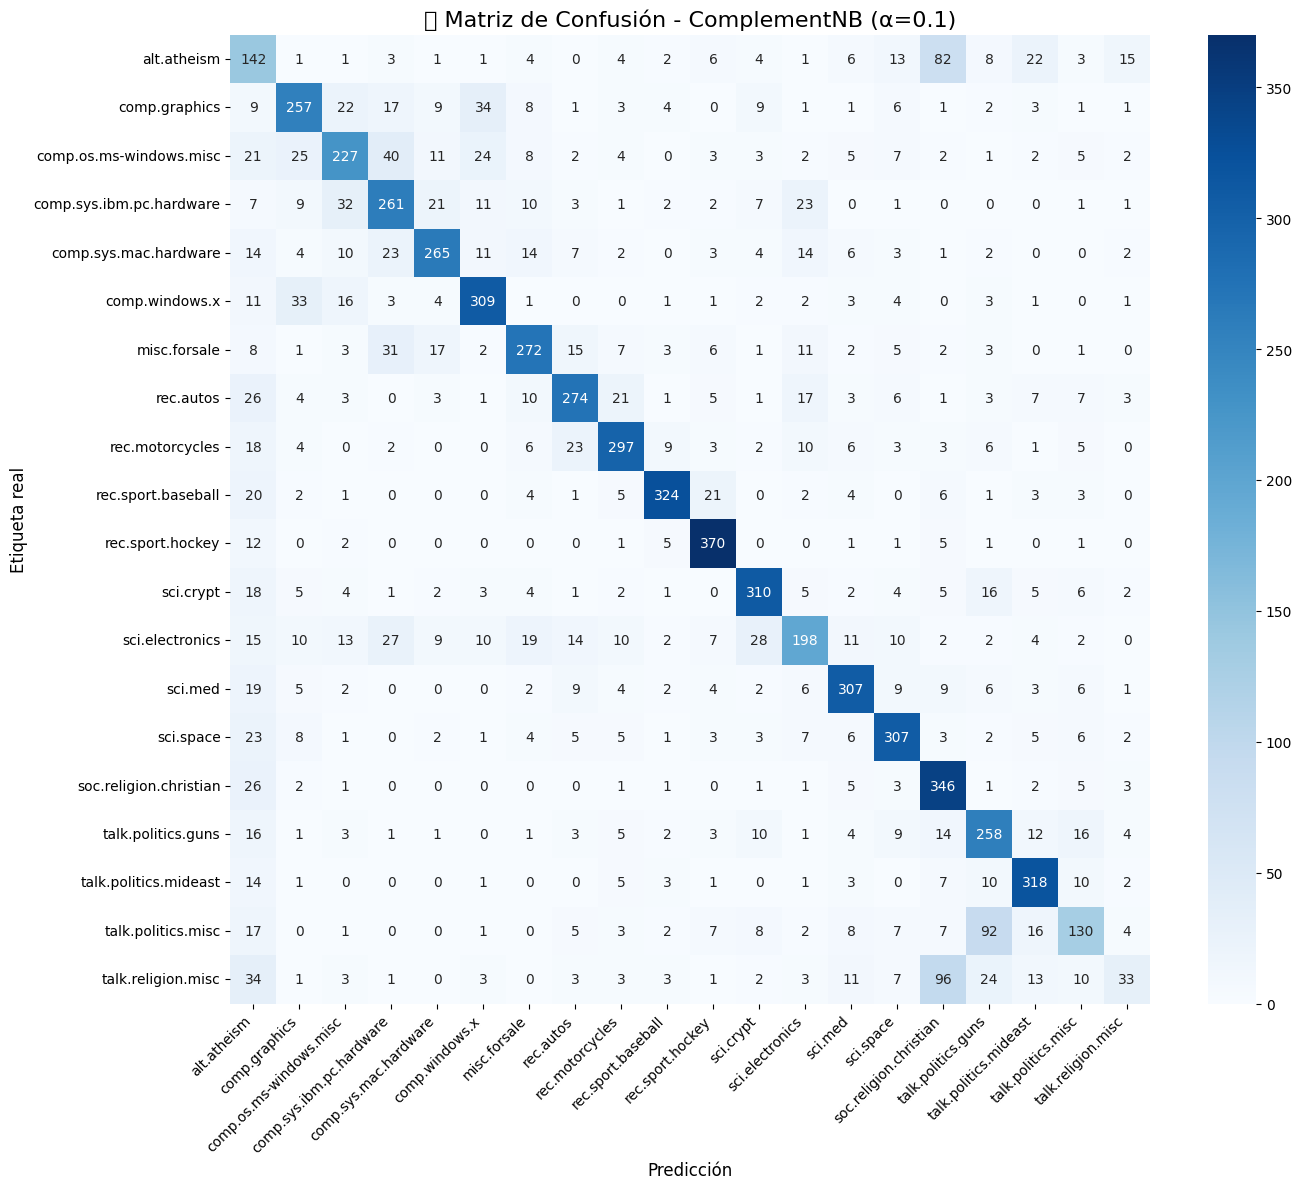

Reporte de Clasificación:

                          precision    recall  f1-score   support

             alt.atheism       0.30      0.45      0.36       319
           comp.graphics       0.69      0.66      0.67       389
 comp.os.ms-windows.misc       0.66      0.58      0.61       394
comp.sys.ibm.pc.hardware       0.64      0.67      0.65       392
   comp.sys.mac.hardware       0.77      0.69      0.73       385
          comp.windows.x       0.75      0.78      0.77       395
            misc.forsale       0.74      0.70      0.72       390
               rec.autos       0.75      0.69      0.72       396
         rec.motorcycles       0.78      0.75      0.76       398
      rec.sport.baseball       0.88      0.82      0.85       397
        rec.sport.hockey       0.83      0.93      0.88       399
               sci.crypt       0.78      0.78      0.78       396
         sci.electronics       0.64      0.50      0.57       393
                 sci.med       0.78      0.78   

In [34]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Vectorización TF-IDF (parámetros óptimos)
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=15000,
    max_df=0.9,
    min_df=5
)

# Vectorización
X_train_tfidf = vectorizer.fit_transform(train.data)
X_test_tfidf = vectorizer.transform(test.data)

# Modelo final
modelo_final = ComplementNB(alpha=0.1)
modelo_final.fit(X_train_tfidf, train.target)

# Predicciones
y_pred = modelo_final.predict(X_test_tfidf)

# Matriz de confusión
conf_matrix = confusion_matrix(test.target, y_pred)
labels = test.target_names

# Gráfico de matriz de confusión
plt.figure(figsize=(14, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('🔍 Matriz de Confusión - ComplementNB (α=0.1)', fontsize=16)
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Etiqueta real', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Reporte detallado
print("Reporte de Clasificación:\n")
print(classification_report(test.target, y_pred, target_names=labels))

El modelo Complement Naive Bayes con α = 0.1 logró un desempeño general sólido en la tarea de clasificación de textos del conjunto 20 Newsgroups. Con una exactitud del 69% y un F1-score macro de 0.67, se evidencia que el modelo es capaz de identificar correctamente muchas de las categorías, aunque con ciertas limitaciones en clases más ambiguas. Este rendimiento es razonable, considerando que se trata de un problema multiclase con 20 categorías temáticamente diversas.

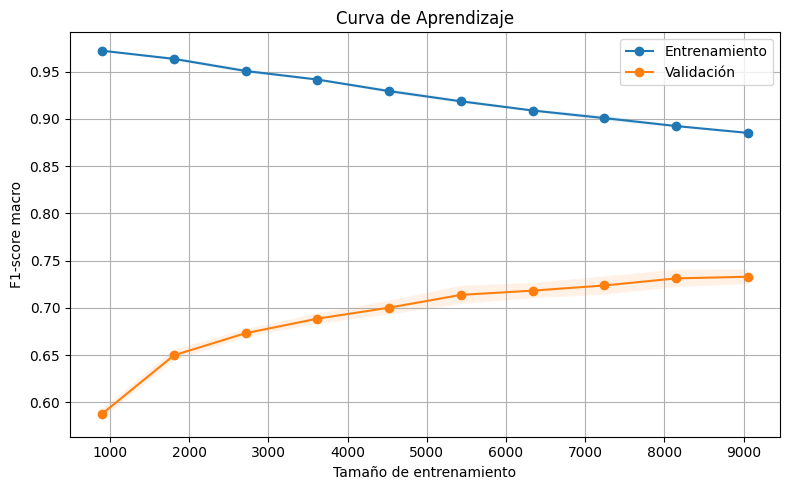

In [35]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Vectorización y modelo
vectorizer = TfidfVectorizer(stop_words='english', max_features=15000, max_df=0.9, min_df=5)
X = vectorizer.fit_transform(train.data)
y = train.target
modelo = ComplementNB(alpha=0.1)

# Curva de aprendizaje
sizes, train_scores, val_scores = learning_curve(modelo, X, y, cv=5, scoring='f1_macro', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
train_mean, val_mean = train_scores.mean(axis=1), val_scores.mean(axis=1)
train_std, val_std = train_scores.std(axis=1), val_scores.std(axis=1)

# Gráfico
plt.figure(figsize=(8, 5))
plt.plot(sizes, train_mean, 'o-', label='Entrenamiento')
plt.plot(sizes, val_mean, 'o-', label='Validación')
plt.fill_between(sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
plt.title('Curva de Aprendizaje')
plt.xlabel('Tamaño de entrenamiento')
plt.ylabel('F1-score macro')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


El modelo ComplementNB aún se beneficia del aumento de datos de entrenamiento. Aunque hay una brecha entre entrenamiento y validación (signo de overfitting leve), la tendencia sugiere que el modelo generaliza mejor con más ejemplos, y podría mejorar más con técnicas como regularización adicional o ajuste de hiperparámetros.

**3**. Transponer la matriz documento-término. De esa manera se obtiene una matriz
término-documento que puede ser interpretada como una colección de vectorización de palabras.
Estudiar ahora similaridad entre palabras tomando 5 palabras y estudiando sus 5 más similares. **La elección de palabras no debe ser al azar para evitar la aparición de términos poco interpretables, elegirlas "manualmente"**.

In [36]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

# Cargar el dataset, solo los documentos de entrenamiento
newsgroups = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

# Vectorización TF-IDF con un número máximo de características y eliminando palabras comunes
vectorizer = TfidfVectorizer(stop_words='english', max_features=15000)
X_tfidf = vectorizer.fit_transform(newsgroups.data)

# Mostrar las formas de las matrices (documento-término)
print(f"Forma de la matriz documento-término: {X_tfidf.shape}")

# Si realmente necesitas la transposición, mantén la forma transpuesta como una variable
X_tfidf_T = X_tfidf.T

# Mostrar la forma de la matriz transpuesta (término-documento)
print(f"Forma de la matriz término-documento: {X_tfidf_T.shape}")


Forma de la matriz documento-término: (11314, 15000)
Forma de la matriz término-documento: (15000, 11314)


In [39]:
from sklearn.metrics.pairwise import cosine_similarity

# Obtener los términos del vectorizador
terms = vectorizer.get_feature_names_out()

# Palabras elegidas manualmente
selected_words = ['computer', 'religion', 'hockey',  'space',  'car']

# Verificar que las palabras seleccionadas existan en el vocabulario
valid_selected_words = [word for word in selected_words if word in vectorizer.vocabulary_]

# Obtener los índices de las palabras elegidas
selected_indices = [vectorizer.vocabulary_[word] for word in valid_selected_words]

# Calcular la similaridad coseno entre todas las palabras
similarities = cosine_similarity(X_tfidf.T)

# Mostrar claramente las 5 palabras más similares para cada palabra seleccionada
for idx in selected_indices:
    word = terms[idx]
    sim_vector = similarities[idx]

    # Evitar autocomparación
    sim_vector[idx] = 0

    # Obtener los índices de las 5 palabras más similares
    top_indices = sim_vector.argsort()[-5:][::-1]

    print(f"\n{'='*60}")
    print(f"Palabra analizada: '{word}'")
    print("Palabras más similares:\n")

    for similar_idx in top_indices:
        similar_word = terms[similar_idx]
        similarity_score = sim_vector[similar_idx]
        print(f"{similar_word:<20} Similitud: {similarity_score:.4f}")




Palabra analizada: 'computer'
Palabras más similares:

shopper              Similitud: 0.1361
verlag               Similitud: 0.1217
drive                Similitud: 0.1100
334                  Similitud: 0.1062
hackers              Similitud: 0.1058

Palabra analizada: 'religion'
Palabras más similares:

religious            Similitud: 0.2365
religions            Similitud: 0.2180
crusades             Similitud: 0.1944
christianity         Similitud: 0.1845
christian            Similitud: 0.1627

Palabra analizada: 'hockey'
Palabras más similares:

ncaa                 Similitud: 0.2572
nhl                  Similitud: 0.2453
players              Similitud: 0.2013
game                 Similitud: 0.1884
league               Similitud: 0.1883

Palabra analizada: 'space'
Palabras más similares:

nasa                 Similitud: 0.3174
shuttle              Similitud: 0.2757
exploration          Similitud: 0.2305
aeronautics          Similitud: 0.2187
launch               Similitud: 0.2110



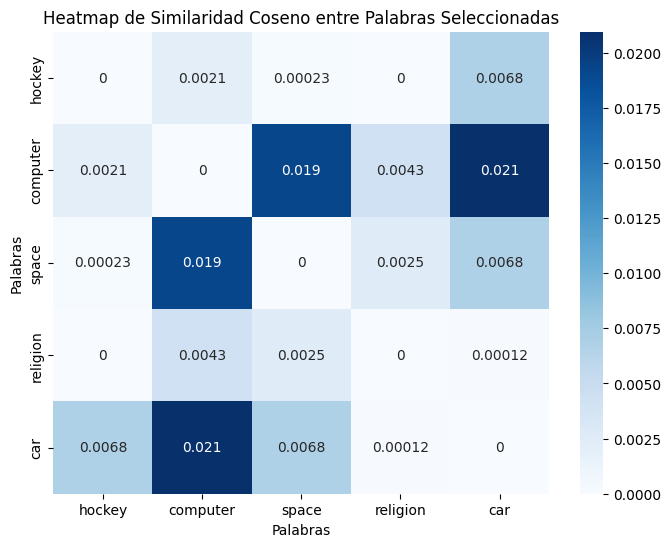

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Palabras elegidas manualmente
selected_words = ['hockey', 'computer', 'space', 'religion', 'car']
selected_indices = [vectorizer.vocabulary_[word] for word in selected_words]

# Crear la matriz de similaridad solo para las palabras seleccionadas
heatmap_values = np.zeros((len(selected_words), len(selected_words)))

# Rellenar la matriz con las similitudes entre las palabras seleccionadas
for i, idx_i in enumerate(selected_indices):
    for j, idx_j in enumerate(selected_indices):
        heatmap_values[i, j] = similarities[idx_i, idx_j]

# Crear el heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_values, annot=True, cmap="Blues", xticklabels=selected_words, yticklabels=selected_words)

# Personalizar el gráfico
plt.title("Heatmap de Similaridad Coseno entre Palabras Seleccionadas")
plt.xlabel("Palabras")
plt.ylabel("Palabras")
plt.show()
